## Introduction

This is an open-source implementation of the paper **Hiding Images in Plain Sight: Deep Steganography, by Shumeet Baluja (Google), at NIPS 2017**. The paper is available [here](https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography).

This code was initially produced with the goal of reproducing to a reasonable degree the results achieved and described in the paper, for the **[Global NIPS Paper Implementation Challenge](https://nurture.ai/nips-challenge/)**.

**Abstract**: Steganography is the practice of concealing a secret message within another, ordinary, message. Commonly, steganography is used to unobtrusively hide a small message within the noisy regions of a larger image. In this study, we attempt to place a full size color image within another image of the same size. Deep neural networks are simultaneously trained to create the hiding and revealing processes and are designed to specifically work as a pair. The system is trained on images drawn randomly from the ImageNet database, and works well on natural images from a wide variety of sources. Beyond demonstrating the successful application of deep learning to hiding images, we carefully examine how the result is achieved and explore extensions. Unlike many popular steganographic methods that encode the secret message within the least significant bits of the carrier image, our approach compresses and distributes the secret image's representation across all of the available bits.

In [1]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

Using TensorFlow backend.


## Config

In [2]:
### Constants ###
DATA_DIR = "data/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge. It can be downloaded [here](https://tiny-imagenet.herokuapp.com/).

Our training set is made of a random subset of images from all 200 classes.

In [3]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [4]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small(10,500)

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


In [5]:
# We split training set into three parts
# 2 parts for secret image and 1 part for cover image.

split_len = X_train.shape[0] // 3
# S_1: secret image  1
input_S_1 = X_train[:split_len]
# S_2
input_S_2 = X_train[split_len:2*split_len]

# C: cover image
input_C = X_train[2*split_len:3*split_len]


In [6]:
input_S = np.concatenate((input_S_1,input_S_2),axis=3)

In [7]:
print ("Number of the frist serect image = " + str(input_S_1.shape[0]))
print ("Number of the second serect image = " + str(input_S_2.shape[0]))
print ("Number of the cover image = " + str(input_C.shape[0]))
print ("combined input_S shape: " + str(input_S.shape)) 

Number of the frist serect image = 666
Number of the second serect image = 666
Number of the cover image = 666
combined input_S shape: (666, 64, 64, 6)


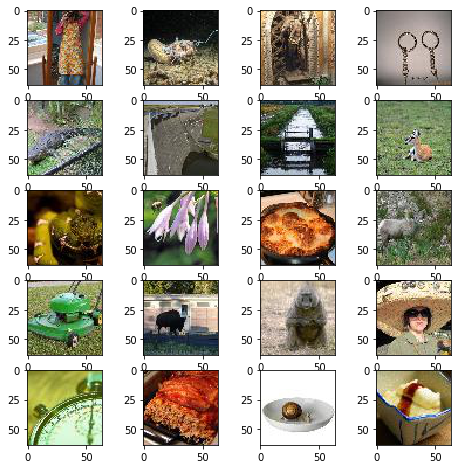

In [8]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()
del X_train

## Model

The model is composed of three parts: The **Preparation Network**, **Hiding Network** (Encoder) and the **Reveal Network**. Its goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'. For stability, we add noise before the Reveal Network, as suggested by the paper. Although the author of the paper didn't originally specify the architecture of the three networks, we discovered aggregated layers showed good results. For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

Note that the loss function for the Reveal Network is different from the loss function for the Preparation and Hiding Networks. In order to correctly implement the updates for the weights in the networks, we create stacked Keras models, one for the Preparation and Hiding Network (which share the same loss function) and one for the Reveal Network. To make sure weights are updated only once, we freeze the weights on the layers of the Reveal Network before adding it to the full model.

![](_images/network.png)

In [9]:
input_size_C = (64,64,3)
input_size_S = (64,64,6)

In [10]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,0:6], y_true[:,6:9]
    s_pred, c_pred = y_pred[:,0:6], y_pred[:,6:9]
    
    c_loss = K.sum(K.square(c_true - c_pred))
    s_loss = rev_loss(s_true, s_pred)
    
    
    return  c_loss + s_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder():
    input_S = Input(shape=(input_size_S))
    input_C= Input(shape=(input_size_C))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size_C))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(6, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model():
    input_S = Input(shape=(input_size_S))
    input_C= Input(shape=(input_size_C))
    
    encoder = make_encoder()
    
    decoder = make_decoder()
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [11]:
encoder_model, reveal_model, autoencoder_model = make_model()

In [15]:
# autoencoder_model.summary()

## Training

Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32. 

In [12]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 1000
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
log = tqdm_notebook(range(NB_EPOCHS),ncols=1000)
for epoch in log:
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = range(0, input_S.shape[0], BATCH_SIZE)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
    log.set_description('Epoch {} | Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

In [19]:
# # Plot loss through epochs
# plt.plot(loss_history)
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

In [ ]:
# Save model
# autoencoder_model.save_weights('model.hdf5')

In [13]:
# Load model
autoencoder_model.load_weights('models/model.hdf5')

## Results

In [14]:
del input_S_1, input_S_2

In [1]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S_1 = decoded[...,0:3]
decoded_S_2 = decoded[...,3:6]
decoded_C = decoded[...,6:9]

NameError: name 'autoencoder_model' is not defined

In [ ]:
# Get absolute difference between the outputs and the expected values.
diff_S_1, diff_S_2, diff_C = np.abs(decoded_S_1 - input_S[...,0:3]), np.abs(decoded_S_2 - input_S[...,3:6]), np.abs(decoded_C - input_C) 

In [ ]:
# def pixel_errors(input_S, input_C, decoded_S, decoded_C):
#     """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
#     see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
#     see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
#     return see_Spixel, see_Cpixel

# def pixel_histogram(diff_S, diff_C):
#     """Calculates histograms of errors for cover and secret image. """
#     diff_Sflat = diff_S.flatten()
#     diff_Cflat = diff_C.flatten()
    
#     fig = plt.figure(figsize=(15, 5))
#     a=fig.add_subplot(1,2,1)
        
#     imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
#     a.set_title('Distribution of error in the Cover image.')
#     plt.axis([0, 250, 0, 0.2])
    
#     a=fig.add_subplot(1,2,2)
#     imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
#     a.set_title('Distribution of errors in the Secret image.')
#     plt.axis([0, 250, 0, 0.2])
    
#     plt.show()

In [ ]:
# # Print pixel-wise average errors in a 256 scale.
# S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

# print ("S error per pixel [0, 255]:", S_error)
# print ("C error per pixel [0, 255]:", C_error)

In [ ]:
# # Plot distribution of errors in cover and secret images.
# pixel_histogram(diff_S, diff_C)

In [ ]:
# # Configs for results display

# # Show images in gray scale
# SHOW_GRAY = False
# # Show difference bettwen predictions and ground truth.
# SHOW_DIFF = True

# # Diff enhance magnitude
# ENHANCE = 1

# # Number of secret and cover pairs to show.
# n = 6

# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
#     ax = plt.subplot(n_rows, n_col, idx)
#     if gray:
#         plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
#     else:
#         plt.imshow(img)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     if first_row:
#         plt.title(title)

# plt.figure(figsize=(14, 15))
# rand_indx = [random.randint(0, 1000) for x in range(n)]
# # for i, idx in enumerate(range(0, n)):
# for i, idx in enumerate(rand_indx):
#     n_col = 6 if SHOW_DIFF else 4
    
#     show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

#     show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
#     show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
#     show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
#     if SHOW_DIFF:
#         show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
#         show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

# plt.show()